# Muon-Decay-Acquire

## The following cell acquires and plots a single-pulse or a double-pulse signal depending on the mode selected.


We use the *periphery module*. Program the FPGA with the command *cat Muon-Decay.bit > /dev/xdevcfg*


TRESHOLD_COUNTS =  8089 for TRESHOLD_VOLT = 0.25  Volt
NUM SINGE-PULSES =  34  NUM DOUBLE-PULSES =  15
Measured Delta Time Between the Two Pulses =   1400  ns
Pointer at trigger=  3965  = 0xf7d


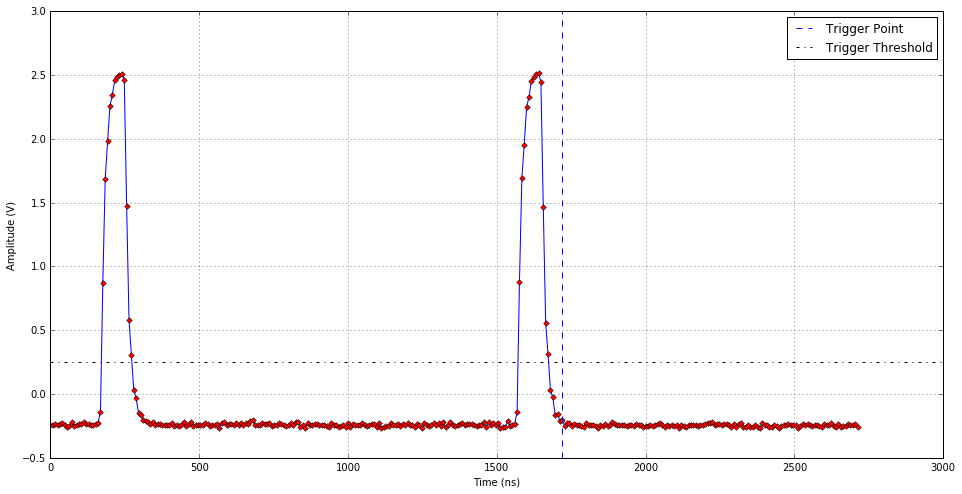

In [17]:
#!/usr/bin/python

##########################################################################inputs
CHANNEL = 1 # 1 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = .25 # Volt
POINTS_SAVE_AFTER_TRIGGER = 1000 # ns
WINDOW_DOUBLE_PULSE = 20000 # ns
EDGE = 0 # 1 for PosEdge trigger  0 for NegEdge trigger

WIDTH = 80 # ns
DELTA_TIME = 1400 # ns
PULSE_TYPE = 0 # 0 for pos 1 for neg
MODE = 1  # # MODE = 0 SINGLE  MODE = 1 DOUBLE
##########################################################################
WINDOW_DOUBLE_PULSE = int(WINDOW_DOUBLE_PULSE/8)
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE

TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")

from periphery import MMIO
#import numpy as np
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256+WINDOW_DOUBLE_PULSE) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256)
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,EDGE) # TRIGGER EDGE
regset.close()

###################DOUBLE PULSE GENERATOR ##########################
WIDTH = int (WIDTH/8) 
DELTA_TIME = int (DELTA_TIME/8)
regset = MMIO(0x41210000, 0xc)
regset.write32(0,DELTA_TIME*256*256+WIDTH*16 + 2*PULSE_TYPE) 
regset.write32(0,DELTA_TIME*256*256+WIDTH*16 + 2*PULSE_TYPE + 1) 
NUM_SINGLES = regset.read32(8) % (256*256)
NUM_DOUBLES = int(regset.read32(8) / (256*256))
print ("NUM SINGE-PULSES = ", NUM_SINGLES, " NUM DOUBLE-PULSES = ",NUM_DOUBLES)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
DT_BETWEEN_PULSES = regset.read32(0)
print("Measured Delta Time Between the Two Pulses =  ",DT_BETWEEN_PULSES*8, " ns")
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256)
    if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
        break  

print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-DT_BETWEEN_PULSES-40,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = (DT_BETWEEN_PULSES+40)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()

## Here we replot the same data using Plotly

In [16]:
import plotly
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
import plotly.graph_objs as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y,mode='lines+markers',
    line=dict(color="green",  width=2),
    marker=dict(color="blue", size=4)))
fig.update_layout(
    title="Double-Pulse Event Produced with the Generator",
    xaxis_title="Time (ns)",
    yaxis_title="Amplitude (V)",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="Black"))
fig.add_vline(x=(DT_BETWEEN_PULSES+40)*8, line_width=1, line_dash="dash", line_color="green")
fig.add_hline(y=TRESHOLD_VOLT, line_width=1, line_dash="dash", line_color="blue")

fig.show()

## Another double-pulse example with different parameters

TRESHOLD_COUNTS =  7577 for TRESHOLD_VOLT = 1.5  Volt
NUM SINGE-PULSES =  37  NUM DOUBLE-PULSES =  16
Measured Delta Time Between the Two Pulses =   3400  ns
Pointer at trigger=  3658  = 0xe4a


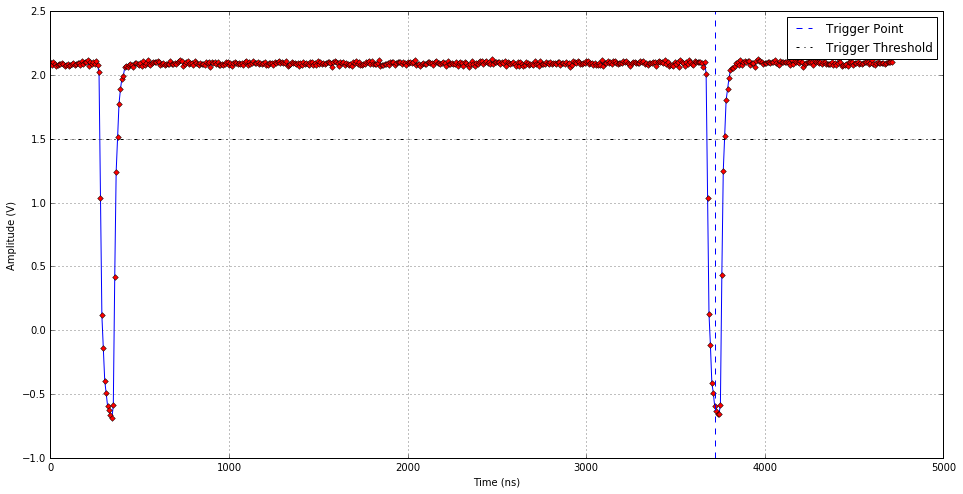

In [18]:
#!/usr/bin/python

##########################################################################inputs
CHANNEL = 1 # 1 
#GAIN = 1 # +- 1 V
GAIN = 20 # +- 20 V, Select one according to your RP jumper LV or HV
TRESHOLD_VOLT = 1.5 # Volt
POINTS_SAVE_AFTER_TRIGGER = 1000 # ns
WINDOW_DOUBLE_PULSE = 20000 # ns
EDGE = 0 # 1 for PosEdge  0 for NegEdga

WIDTH = 80 # ns
DELTA_TIME = 3400 # ns
PULSE_TYPE = 1 # 0 for pos 1 for neg
MODE = 1  # # MODE = 0 SINGLE  MODE = 1 DOUBLE
##########################################################################
WINDOW_DOUBLE_PULSE = int(WINDOW_DOUBLE_PULSE/8)
POINTS_SAVE_AFTER_TRIGGER = int(POINTS_SAVE_AFTER_TRIGGER/8)
POINTS_BEFORE_TRIGGER = WINDOW_DOUBLE_PULSE

TRESHOLD_COUNTS = int(TRESHOLD_VOLT * 2**14/(-2*GAIN) + 2**13)
print ("TRESHOLD_COUNTS = ", TRESHOLD_COUNTS , "for TRESHOLD_VOLT =",TRESHOLD_VOLT, " Volt")

from periphery import MMIO
#import numpy as np
####################################################################
regset = MMIO(0x41220000, 0xc)
regset.write32(0,POINTS_SAVE_AFTER_TRIGGER*256*256+WINDOW_DOUBLE_PULSE) # POINTS_AFTER_TRIGGER and WINDOW_DOUBLE_PULSE
regset.write32(8,MODE) # MODE = 0 SINGLE  MODE = 1 DOUBLE
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
regset.write32(0,TRESHOLD_COUNTS*256*256) # TRESHOLD 
ADDR_TRIG_OLD = int(regset.read32(8)/256/256)
regset.write32(0,TRESHOLD_COUNTS*256*256+2) # TRESHOLD and ENABLE TRIGGER
regset.write32(0,TRESHOLD_COUNTS*256*256)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
regset.write32(8,EDGE) # TRIGGER EDGE
regset.close()

###################DOUBLE PULSE GENERATOR ##########################
WIDTH = int (WIDTH/8) 
DELTA_TIME = int (DELTA_TIME/8)
regset = MMIO(0x41210000, 0xc)
regset.write32(0,DELTA_TIME*256*256+WIDTH*16 + 2*PULSE_TYPE) 
regset.write32(0,DELTA_TIME*256*256+WIDTH*16 + 2*PULSE_TYPE + 1) 
NUM_SINGLES = regset.read32(8) % (256*256)
NUM_DOUBLES = int(regset.read32(8) / (256*256))
print ("NUM SINGE-PULSES = ", NUM_SINGLES, " NUM DOUBLE-PULSES = ",NUM_DOUBLES)
regset.close()
####################################################################
regset = MMIO(0x41230000, 0xc)
DT_BETWEEN_PULSES = regset.read32(0)
print("Measured Delta Time Between the Two Pulses =  ",DT_BETWEEN_PULSES*8, " ns")
regset.close()
####################################################################
regset = MMIO(0x41200000, 0xc)
while(1):
    ADDR_TRIG_NEW =  int(regset.read32(8)/256/256)
    if ADDR_TRIG_NEW != ADDR_TRIG_OLD:   # TRIGGER DETECTED
        break  

print("Pointer at trigger= ",ADDR_TRIG_NEW," =",hex(ADDR_TRIG_NEW))
dat = []
n = 0
for ADDR_B in range(ADDR_TRIG_NEW-DT_BETWEEN_PULSES-40,ADDR_TRIG_NEW+ POINTS_SAVE_AFTER_TRIGGER,1):
    n += 1
    ADDR_B = ADDR_B%2**12
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16)
    regset.write32(0,TRESHOLD_COUNTS*256*256+ADDR_B*16+1)
    COUNTS = regset.read32(8)%(256*256)
    DATA_VOLT = -2*GAIN*(COUNTS-2**13)/2**14
    dat.append(DATA_VOLT)
regset.close()
####################################################################
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()
fig.set_size_inches([16,8])
y = dat
x = [i*8 for i in range(len(y))]
ax1.plot(x, y, '-bD',  c='blue', mfc='red', mec='k',ms=4)
ax1.axvline(x = (DT_BETWEEN_PULSES+40)*8, color='b', ls='--', lw=1, label='Trigger Point')
ax1.axhline(y = TRESHOLD_VOLT, color='k', ls='-.', lw=1, label='Trigger Threshold')
ax1.grid()
ax1.set_xlabel("Time (ns)")
ax1.set_ylabel("Amplitude (V)")
ax1.legend()
plt.show()